# 삼성 DS-KAIST AI Expert 프로그램
## Transfer Learning

실습 문제: Attention Transfer

담당 조교: 탁지훈 (jihoontack@kaist.ac.kr), 모상우 (swmo@kaist.ac.kr)

# Introduction

본 실습 문제에서는 TensorFlow와 Keras 프레임워크를 이용하여, transfer learning (attention transfer)에 관한 문제를 풀어볼 예정입니다.

Introduction에서는 (1) library 호출, (2) training & test dataset 호출 그리고 (3) teacher network 학습을 진행합니다.

In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

### Hyperparamters

아래는 이번 실습에서 사용할 hyperparameter들을 사전 정의해 둔 것입니다.

In [3]:
batch_size = 128
steps_per_epoch = 300
num_epochs = 10

이번 실습에서 사용할 dataset은 CIFAR-10 입니다. 각 dataset은 총 50000개의 training image를 가지고 있고, 10000개의 test image를 가지고 있습니다. CIFAR-10의 이미지는 10개의 class중 하나에 속하게 됩니다.

In [4]:
cifar10 = tf.keras.datasets.cifar10

In [5]:
(x_train_c10, y_train_c10), (x_test_c10, y_test_c10) = cifar10.load_data()

In [6]:
print('CIFAR-10 ------')
print('트레이닝 샘플 수: %d' % x_train_c10.shape[0])
print('이미지 크기: %d x %d x %d' % (x_train_c10.shape[1], x_train_c10.shape[2], x_train_c10.shape[3]))
print('트레이닝 데이터 크기: %d x %d x %d x %d' % (*x_train_c10.shape, ))

CIFAR-10 ------
트레이닝 샘플 수: 50000
이미지 크기: 32 x 32 x 3
트레이닝 데이터 크기: 50000 x 32 x 32 x 3


### Preprocessing Data
Image의 pixel 의 값은 (R, G, B) 형태로 표현되고, 각 channel (R/G/B) 마다 [0, 1, 2, ..., 255] 의 정수 값을 가집니다. 일반적으로 neural network를 학습할 때에는 normalized 되어있는 값을 input으로 사용하는 것이 좋습니다. 따라서, 각 image 값들을 [0, 1/255, ..., 1.0] 의 실수 값으로 치환해줍니다.
Image의 label 은 [0, 1, 2, ..., 9] 의 값을 가집니다. 이러한 label 정보는 일반적으로 one-hot encoding으로 바꿔주어 사용합니다. one-hot encoding을 하게 되면 label 0은 [1, 0, 0, ..., 0], label 1은 [0, 1, 0, ..., 0], 그리고 label 9는 [0, 0, 0, ..., 1]으로 바뀌게 됩니다.

In [7]:
x_train_c10 = x_train_c10 / 255.0
x_test_c10 = x_test_c10 / 255.0

y_train_c10 = tf.keras.utils.to_categorical(y_train_c10, 10)
y_test_c10 = tf.keras.utils.to_categorical(y_test_c10, 10)

### Data Generator

`ImageDataGenerator`는 Keras에 있는 API 중 하나로, data augmentation (좌우 반전 등) 을 손쉽게 할 수 있습니다. 가능한 data augmentation 방법들은 내용은 https://keras.io/preprocessing/image/ 에서 확인하실 수 있습니다. 이번 실습에서는 일반적으로 CIFAR dataset에서 사용하는 random 상하좌우 shift와 좌우 반전을 사용할 것입니다.

In [8]:
datagen_c10 = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=5,
    fill_mode='constant',
    horizontal_flip=True).flow(x_train_c10, y_train_c10, batch_size=batch_size)

### Plotting Images

아래의 script를 이용하여 각 데이터셋에 어떤 이미지들이 들어있는지 확인할 수 있습니다.

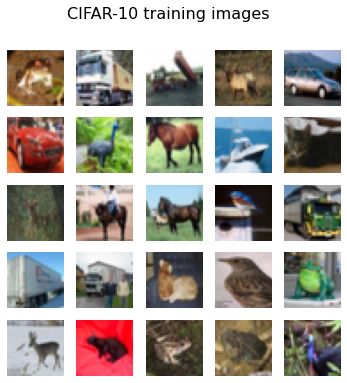

In [9]:
plt.figure(figsize=(6,6))
plt.suptitle('CIFAR-10 training images', fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_c10[i])
    plt.axis('off')


이번 실습에서는 간단한 6-layer CNN을 사용할 것입니다.

`build_conv_block`은 convolutional layer와, batch normalization layer, 그리고 relu activation으로 구성된 하나의 convolutional block입니다.

In [10]:
def build_conv_block(inputs, num_channels):
    inputs = Conv2D(num_channels, (3, 3), padding='same')(inputs)
    inputs = BatchNormalization()(inputs)
    inputs = Activation('relu')(inputs)
    return inputs

`build_network`는 하나의 CNN을 만드는 역할을 합니다. 이 함수는 `inputs`, `num_classes`, `base_width` 세 개의 인자를 받습니다.
- `inputs`: model의 input shape을 나타내는 역할을 합니다.
- `num_classes`: 최종 output dimension을 나타냅니다. classification 문제의 경우, label의 종류의 수와 같습니다.
- `base_width`: network의 width를 나타내는 역할을 합니다. teacher model로 wide한 모델을 사용할 것이고, student 모델로는 thin한 모델을 사용할 예정입니다.

`build_network`는 총 5개의 tensor를 return합니다.
- `outputs`: network의 최종 출력값으로, softmax activation이 이루어진 값입니다.
- `logits`: softmax activation을 하기 직전의 값입니다. 이 값은 knowledge distillation method에서 사용될 예정입니다. 
- `x1`, `x2`, `x3`: pooling 직전의 hidden feature map을 나타냅니다. 이 hidden feature map들은 추후에 attention transfer를 할 때 쓰일 예정입니다.

In [11]:
def build_network(inputs, num_classes=10, base_width=16):
    x1 = build_conv_block(inputs, base_width)
    x1 = build_conv_block(x1, base_width)
    
    x2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x1)
    x2 = build_conv_block(x2, base_width*2)
    x2 = build_conv_block(x2, base_width*2)

    x3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x2)
    x3 = build_conv_block(x3, base_width*4)
    x3 = build_conv_block(x3, base_width*4)

    logits = GlobalAveragePooling2D()(x3)
    logits = Dense(num_classes)(logits)
    outputs = Activation('softmax')(logits)
    
    return outputs, logits, x1, x2, x3

In [12]:
inputs = Input(shape=(32, 32, 3))

## Define Teacher Model

먼저, `base_width=16`인 teacher network를 정의하고, initial weights를 저장합니다.

In [13]:
outputs_t, logits_t, x1_t, x2_t, x3_t = build_network(inputs, base_width=16)
teacher = tf.keras.models.Model(inputs=inputs, outputs=outputs_t, name='teacher')
teacher.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_______

In [14]:
teacher.save_weights('teacher_init.h5')

## Define Student Model

이제 `base_width=8`인 student network를 정의하고, initial weights를 저장합니다. Transfer learning을 이용하여 student network의 성능을 올려볼 예정입니다.

In [15]:
outputs_s, logits_s, x1_s, x2_s, x3_s = build_network(inputs, base_width=8)
student = tf.keras.models.Model(inputs=inputs, outputs=outputs_s, name='student')
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 8)         0   

In [16]:
student.save_weights('student_init.h5')

아래 함수 `plot_history`는 training curve를 시각화하는 함수입니다. 학습 후 성능이 어떻게 변화하는지 관측해볼 것입니다.

In [17]:
def plot_history(history):
    epochs = len(history.history['loss'])
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(range(epochs), history.history['loss'], 'r')
    plt.plot(range(epochs), history.history['val_loss'], 'b')
    plt.legend(['train', 'val'])

    plt.subplot(1, 2, 2)
    plt.title('accuracy')
    plt.plot(range(epochs), history.history['acc'], 'r--')
    plt.plot(range(epochs), history.history['val_acc'], 'b--')    
    plt.legend(['train', 'val'])

    print('최대 도달 성능: %.2f%%' % (max(history.history['val_acc'])*100,))

## Train Teacher Network

Transfer learning을 하기에 앞서, Keras의 `compile` 함수를 이용하여 optimizer, loss, metric을 선언해줍니다.

In [18]:
teacher.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

그리고 Model의 `fit_generator`를 사용하여 네트워크를 학습해줍니다. 여기서 `generator`는 위에서 선언한 data augmentation이 된 dataset으로 생각할 수 있습니다. `steps_per_epoch`은 한 epoch마다 iteration 수를, `epochs`는 총 epoch을 나타냅니다.

In [19]:
history = teacher.fit_generator(datagen_c10,
                                steps_per_epoch=steps_per_epoch,
                                epochs=num_epochs,
                                validation_data=(x_test_c10, y_test_c10))

Epoch 1/10
300/300 [==============================] - 48s 160ms/step - loss: 1.4542 - acc: 0.4753 - val_loss: 2.4756 - val_acc: 0.2418
Epoch 2/10
300/300 [==============================] - 45s 149ms/step - loss: 1.1128 - acc: 0.6032 - val_loss: 1.4873 - val_acc: 0.4991
Epoch 3/10
300/300 [==============================] - 44s 146ms/step - loss: 0.9860 - acc: 0.6500 - val_loss: 1.0473 - val_acc: 0.6268
Epoch 4/10
300/300 [==============================] - 43s 145ms/step - loss: 0.9137 - acc: 0.6759 - val_loss: 1.5020 - val_acc: 0.5291
Epoch 5/10
300/300 [==============================] - 44s 145ms/step - loss: 0.8540 - acc: 0.6990 - val_loss: 1.2421 - val_acc: 0.5745
Epoch 6/10
300/300 [==============================] - 43s 145ms/step - loss: 0.8152 - acc: 0.7132 - val_loss: 1.0969 - val_acc: 0.6212
Epoch 7/10
300/300 [==============================] - 43s 145ms/step - loss: 0.7669 - acc: 0.7300 - val_loss: 1.0559 - val_acc: 0.6381
Epoch 8/10
300/300 [==============================] - 4

위에서 선언한 `plot_history` 함수를 이용하여 학습이 어떻게 되었는지 확인해봅니다.

최대 도달 성능: 71.64%


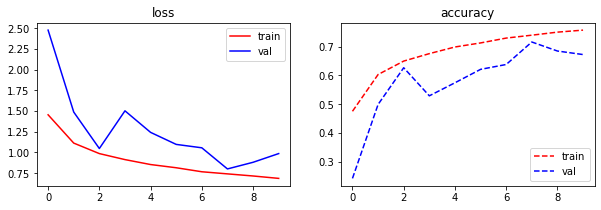

In [20]:
plot_history(history)

teacher는 이제 더 이상 학습하지 않고, transfer learning에만 쓰일 예정이므로, 학습이 되지 않도록 `trainable` 을 `False`로 만들어줍니다.

In [21]:
teacher.trainable = False

## Q. Attention Transfer를 이용하여 모델 성능 개선시키기

$x_t$, $x_s$를 teacher/student의 feature map 값이라고 할 때, attention transfer의 식은 아래와 같습니다.

\begin{align}
a_t & = \sum_{i=1}^{C} |x_t^{(i)}| \\
a_s & = \sum_{i=1}^{C} |x_s^{(i)}| \\
\mathcal{L}_\text{AT} (x_t, x_s) & = \left\lVert \frac{\text{vec}(a_t)}{\lVert\text{vec}(a_t)\rVert_2} - \frac{\text{vec}(a_s)}{\lVert\text{vec}(a_s)\rVert_2}\right\rVert_2
\end{align}

아래의 함수(링크 참조)를 이용하여, 위의 knowledge distillation loss $\mathcal{L}_\text{AT} (x_t, x_s)$를 구현하세요.
- [`tf.math.abs`](https://www.tensorflow.org/api_docs/python/tf/math/abs) : 절대값 연산 $|\cdot|$ 을 할 때 사용됩니다.
- [`tf.math.reduce_sum`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum) : $\sum_{i=1}^C$ 할 때 사용합니다.
- [`tf.keras.layers.Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) : attention map $a_t$ 혹은 $a_s$ 를 vector로 만들어줄 때 사용합니다.
- [`tf.math.l2_normalize`](https://www.tensorflow.org/api_docs/python/tf/math/l2_normalize) : vector를 normalize할 때 사용합니다.
- [`tf.norm`](https://www.tensorflow.org/api_docs/python/tf/norm) : vector의 norm을 구할 때 사용합니다.
- [`tf.math.reduce_mean`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean) : batch의 모든 sample에 대해서 average를 취할 때 사용합니다.

In [22]:
def attention_transfer(x_t, x_s):
    # Q: attention transfer 구현
    a_t = tf.math.reduce_sum(tf.math.abs(x_t), axis=3)
    a_s = tf.math.reduce_sum(tf.math.abs(x_s), axis=3)
    a_t = tf.keras.layers.Flatten()(a_t)
    a_t = tf.math.l2_normalize(a_t, axis=1)
    a_s = tf.keras.layers.Flatten()(a_s)
    a_s = tf.math.l2_normalize(a_s, axis=1)
    loss = tf.math.reduce_mean(tf.norm(a_t-a_s, axis=1))
    return loss

이제, CNN을 학습하기 위한 loss function을 정의합니다. 아래에서 `at_weight` 는 attention transfer loss의 비중을 나타냅니다. AT loss는 각 hidden feature map 쌍(e.g., `x1_t`와 `x1_s`)에 대해 추가해주어야 합니다.

In [23]:
def loss_with_at(y_true, y_pred):
    at_weight = 0.1
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    loss = loss + at_weight * attention_transfer(x1_t, x1_s)
    loss = loss + at_weight * attention_transfer(x2_t, x2_s)
    loss = loss + at_weight * attention_transfer(x3_t, x3_s)
    return loss

In [24]:
# student model을 초기화해줍니다.
student.load_weights('student_init.h5')
student.compile(optimizer='adam',
                loss=loss_with_at,      # 이 부분이 기존의 compile과 다릅니다.
                metrics=['accuracy'])

In [25]:
# student model을 학습합니다.
history = student.fit_generator(datagen_c10,
                                steps_per_epoch=steps_per_epoch,
                                epochs=num_epochs,
                                validation_data=(x_test_c10, y_test_c10))

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
300/300 [==============================] - 37s 123ms/step - loss: 1.8371 - acc: 0.3818 - val_loss: 2.0587 - val_acc: 0.2976
Epoch 2/10
300/300 [==============================] - 34s 113ms/step - loss: 1.4388 - acc: 0.5191 - val_loss: 1.7061 - val_acc: 0.4437
Epoch 3/10
300/300 [==============================] - 34s 113ms/step - loss: 1.2958 - acc: 0.5666 - val_loss: 1.5159 - val_acc: 0.4968
Epoch 4/10
300/300 [==============================] - 34s 112ms/step - loss: 1.2137 - acc: 0.5957 - val_loss: 1.3653 - val_acc: 0.5465
Epoch 5/10
300/300 [==============================] - 34s 112ms/step - loss: 1.1669 - acc: 0.6109 - val_loss: 1.3986 - val_acc: 0.5360
Epoch 6/10
300/300 [==============================] - 34s 112ms/step - loss: 1.1218 - acc: 0.6258 - val_loss: 1.4254 - val_acc: 0.5413
Epoch 7/10
300/300 [==============================] - 34s 113ms/step - loss: 1.0932 - acc: 0.637

최대 도달 성능: 60.10%


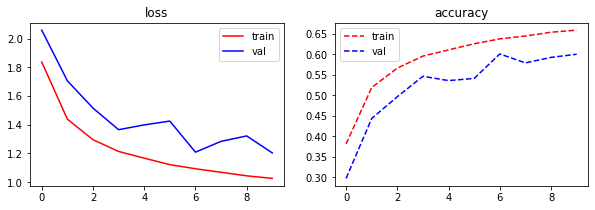

In [26]:
# student model의 학습 결과를 확인합니다.
plot_history(history)